In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])



In [3]:
timer = logit_glmm.Timer()

In [4]:
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])

glmm_par_draw = vb.ModelParamsDict('GLMM Parameter Draw')
glmm_par_draw.push_param(vb.ScalarParam('mu', val=0.0))
glmm_par_draw.push_param(vb.ScalarParam('tau', val=1.0))
glmm_par_draw.push_param(vb.VectorParam('beta', K, val=np.full(K, 0.)))
glmm_par_draw.push_param(vb.VectorParam('u', NG))


In [5]:
def optimize_with_weights(
    model, weights, init_par, preconditioner, gtol=1e-8, print_every=1):

    model.use_weights = True
    model.weights = copy.deepcopy(weights)
    preconditioned_init_par = sp.sparse.linalg.spsolve(preconditioner, init_par)
    return model.tr_optimize_cond(
        preconditioned_init_par,
        preconditioner=preconditioner,
        num_gh_points=model.num_gh_points,
        gtol=gtol,
        print_every=print_every)   
   

glmm_par_free = vb_data['glmm_par_free']
elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
moment_jac = vb_data['moment_jac']
print(elbo_hess.shape)

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)


(214, 214)


In [6]:
# Pre-condition with the ELBO Hessian from the original analysis.

elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
preconditioner = sp.sparse.diags([1 / np.sqrt(-1. * elbo_hess.diagonal())], [0])
# cond_init = sp.sparse.linalg.spsolve(preconditioner, glmm_par_free)


In [7]:
base_weights = np.full(NObs, 1.0)
print(np.sum(base_weights))
base_opt = optimize_with_weights(
    model=model,
    preconditioner=preconditioner,
    weights=base_weights,
    init_par=glmm_par_free,
    gtol=1e-8)
base_free_par = model.objective.uncondition_x(base_opt.x)

1000.0


/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Iter  0  value:  69.4078730719
Iter  1  value:  69.4078730719
         Current function value: 69.407873
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0


In [8]:
timer.tic()
moment_jac = moment_wrapper.get_moment_jacobian(base_free_par)
timer.toc('moment_jac_time')

moment_jac_sp = sp.sparse.csr_matrix(moment_jac)

print('Time: ', timer.time_dict['moment_jac_time'])


Time:  0.0784904956817627


In [9]:
# Get a sparse Jacobian.
timer.tic()
weight_jacobian = model.get_sparse_weight_free_jacobian(base_free_par, print_every_n=200)
timer.toc('weight_jac_time')
print('Jacobian time: ', timer.time_dict['weight_jac_time'])

Group 0 of 99
Jacobian time:  0.9953129291534424


In [10]:
# Get a sparse Hessian.
timer.tic()
kl_hess = model.get_sparse_free_hessian(base_free_par, print_every_n=200)
timer.toc('hess_time')
print('Hessian time: ', timer.time_dict['hess_time'])

Group 0 of 99.
Hessian time:  6.881932735443115


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [11]:
# Invert to get parameter sensitivity.
from scikits.sparse.cholmod import cholesky
timer.tic()
print('Cholesky...')
kl_hess_chol = cholesky(kl_hess)
print('Solving...')
param_boot_mat = -1 * kl_hess_chol.solve_A(weight_jacobian.T)
print('Done.')
timer.toc('inverse_time')

Cholesky:
Solving:
Done.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  import sys


In [12]:
# Evaluated at a linear combination of the bootstrap draw and base weights.
# Note that at the full bootstrap draw, the response is quite nonlinear.

use_jackknife = True
if use_jackknife:
    boot_draw = copy.deepcopy(base_weights)
    boot_draw[np.random.randint(NObs)] = 0.
else:
    boot_draw = np.random.multinomial(NObs, [1. / NObs] * NObs, size=1) - 1.0
    boot_draw = 1.0 * boot_draw + base_weights

print('Total weight (there are {} observations): {}'.format(NObs, np.sum(boot_draw)))

lr_boot_time = time.time()
lr_param_diff = param_boot_mat * (np.squeeze(boot_draw) - 1.0)
lr_boot_time = time.time() - lr_boot_time

print('lr_boot_time: ', lr_boot_time)


Total weight (there are 1000 observations): 999.0
lr_boot_time:  0.0003864765167236328


In [13]:
#preconditioner = sp.sparse.diags([1 / np.sqrt(kl_hess.diagonal())], [0])
# cond_init = sp.sparse.linalg.spsolve(preconditioner, base_free_par + lr_param_diff)

timer.tic()
glmm_par_opt_boot = optimize_with_weights(
    model=model,
    preconditioner=preconditioner,
    init_par=base_free_par + lr_param_diff,
    weights=boot_draw, gtol=1e-8)
boot_free_par = model.objective.uncondition_x(glmm_par_opt_boot.x)
timer.toc('re_optimization_time')

print('Re-optimization time: ', timer.time_dict['re_optimization_time'])

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Iter  0  value:  69.4078613857
Iter  1  value:  69.4078613857
         Current function value: 69.407861
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Re-optimization time:  0.44806528091430664


True param difference: 4.2174465358461875e-05
True moment norm difference: 3.904644060857067e-05


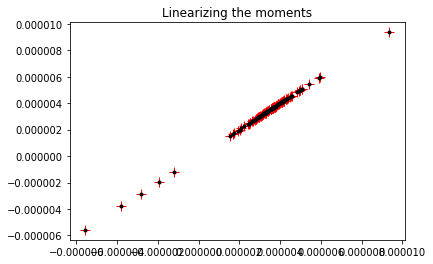

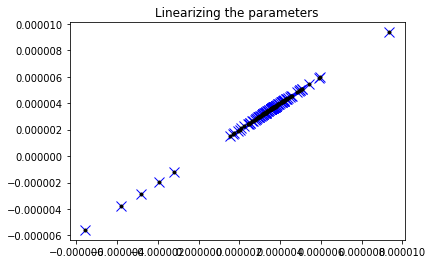

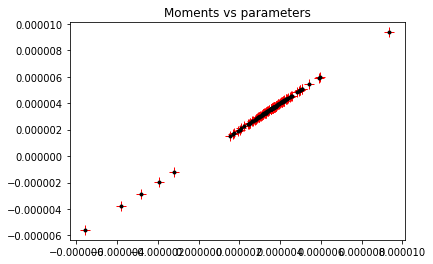

In [14]:
# The actual change in the moment vectors.
moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)
moment_vec_boot = moment_wrapper.get_moment_vector_from_free(boot_free_par)
true_moment_diff = moment_vec_boot - moment_vec
print('True param difference: {}'.format(np.linalg.norm(base_free_par - boot_free_par)))
print('True moment norm difference: {}'.format(np.linalg.norm(true_moment_diff)))

# Use the linear approximation for the parameters, not the moments.
moment_pred_from_params = \
    moment_wrapper.get_moment_vector_from_free(base_free_par + lr_param_diff)
moment_pred_from_params_diff = moment_pred_from_params - moment_vec

# The difference based on a linear approximation to the moments.
# lr_moment_diff = \
#     moment_jac_sp * (param_boot_mat * (np.squeeze(boot_draw) - 1.0))
moment_pred_from_moments_diff = moment_jac_sp * lr_param_diff
    

plt.figure()
plt.title('Linearizing the moments')
plt.plot(true_moment_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

plt.figure()
plt.title('Linearizing the parameters')
plt.plot(true_moment_diff, moment_pred_from_params_diff, 'bx', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

plt.figure()
plt.title('Moments vs parameters')
plt.plot(moment_pred_from_params_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(moment_pred_from_params_diff, moment_pred_from_params_diff, 'k.')
#plt.axis([-10, 10, -10, 10])



In [15]:
# Each column corresponds -1 times to a jackknife sample.
print(param_boot_mat.shape)
print()

def get_jackknife_moments(obs):
    lr_diff = np.squeeze(np.asarray(param_boot_mat[:, obs].todense()))
    return moment_wrapper.get_moment_vector_from_free(base_free_par - lr_diff)

timer.tic()
moment_par_jackknife_list = []
for obs in range(NObs):
    if obs % 5000 == 0:
        print('Obs {} of {}'.format(obs, NObs))
    moment_par_jackknife_list.append(get_jackknife_moments(obs))
timer.toc('lr_jackknife_time')

print('Jackknife time: ', timer.time_dict['lr_jackknife_time'])

(214, 1000)

Obs 0 of 1000
Jackknife time:  0.46415019035339355


In [16]:
# Write the result to a JSON file for use in R.

run_name = 'jackknife'

pickle_result_filename = os.path.join(data_dir, '%s_python_vb_jackknife_results.pkl' % analysis_name)
pickle_output = open(pickle_result_filename, 'wb')

# Unlike with JSON, numpy arrays can be pickled.
pickle_result_dict = {  'moment_par_jackknife_list': moment_par_jackknife_list,
                        'run_name': run_name,
                        'timer': timer,
                        'base_free_par': base_free_par,
                        'boot_free_par': boot_free_par,
                        'boot_draw': boot_draw,
                        'kl_hess': vb_sparse.pack_csr_matrix(kl_hess),
                        'param_boot_mat': vb_sparse.pack_csr_matrix(param_boot_mat),
                        'moment_jac': moment_jac }

# Pickle dictionary using protocol 0.
pickle.dump(pickle_result_dict, pickle_output)
pickle_output.close()

print(pickle_result_filename)


print('\n\nDONE.')


/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_small_python_vb_jackknife_results.pkl


DONE.
